In [ ]:
# Adding the neccecary imports to our code
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pydot # conda install pydot
import time
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
import math

In [ ]:
#type of data:
url_Les_Miserables_network  = 'Downloads/LesMiserables.dot'
url_Rome_graph  = '../data/rome.dot'
url_Jazz_Network  = 'Downloads/JazzNetwork.dot'
url_Small_Directed_Network  = '/content/noname.dot'
url_Pro_League_Network  = '/content/LeagueNetwork.dot'
url_Argumentation_network  = '../data/devonshiredebate_withclusters.dot'
url_Political_blogosphere_network  = '../data/polblogs.dot'

url=url_Jazz_Network

In [ ]:
# classes
class Vertex:
    def __init__(self, id, x, y):
        self.id = id
        self.x = x
        self.y = y
        self.neighbors = []

        self.parents = []
        self.children = []

    def add_neighbor(self,neighbor):
        self.neighbors.append(neighbor)
    def add_parents(self,parent):
        self.parents.append(parent)
    def add_children(self,child):
        self.children.append(child)


class Edge:
    def __init__(self, start, end, weight):
        self.start = start
        self.end = end
        #############################
        self.weight = weight
        ###########################

class Graph:
    def __init__(self):
        self.vertices = []
        self.edges = []

    def add_vertex(self, vertex):
        self.vertices.append(vertex)

    def add_edge(self, edge):
        self.edges.append(edge)

    def get_vertex(self, id):
        for vertex in self.vertices:
            if vertex.id == id:
                return vertex

    def remove_edge(self, start, end):
        for edge in self.edges:
            if edge.start == start and edge.end == end:
                self.edges.remove(edge)

    def remove_vertex(self, id):
        for vertex in self.vertices:
            if vertex.id == id:
                self.vertices.remove(vertex)

    def update_x_y(self,id,x,y):
      for vertex in self.vertices:
            if vertex.id == id:
              vertex.x = x
              vertex.y = y


    def visualize_graph(self, custom_figsize, radius):  # O(V + V + E) = O(2V + E) = O(V + E)

      self.place_vertices_in_circle(radius)  # O(V)

      fig, ax = plt.subplots(figsize=(custom_figsize, custom_figsize))  # Adjust width and height as needed
      # Plot Vertices
      scaling_factor = 1 / len(self.vertices)
      for vertex in self.vertices:  # O(V)
          ax.scatter(vertex.x, vertex.y, color='blue', zorder=2, s=scaling_factor * 40000 * (custom_figsize / 15),
                    edgecolors='black')
          ax.text(vertex.x, vertex.y, str(vertex.id), fontsize=(scaling_factor * 40000 * (custom_figsize / 15)) / 100,
                  ha='center', va='center', zorder=len(self.vertices) * scaling_factor * 2, color='white')
      # Plot edges with direction
      for edge in self.edges:  # O(E)
          start = edge.start
          end = edge.end
          dx = end.x - start.x
          dy = end.y - start.y
          ax.annotate("", xy=(end.x, end.y), xytext=(start.x, start.y),
                      arrowprops=dict(arrowstyle="->", linewidth=2.0, color='gray'))

      ax.set_xlabel('X')
      ax.set_ylabel('Y')
      ax.set_title('Graph Visualization with Edge Direction')
      ax.grid(True)
      plt.show()


    def place_vertices_in_circle(self,radius): # O(V)
        num_vertices = len(self.vertices)
        radius = radius  # Radius of the circle
        center_x = 0
        center_y = 0
        angle_increment = 2 * np.pi / num_vertices

        # Place vertices in a bit of randomized circle
        for i, vertex in enumerate(self.vertices): # O(V)
            angle = i * angle_increment
            vertex.x = center_x + radius * np.cos(angle)
            vertex.y = center_y + radius * np.sin(angle)




In [ ]:
def create_custom_graph(G): # O(V) + O(E) + O(V) + O(E) = O(2V + 2E) = O(V + E)
    # Parsing the vertices and edges from the generated graph into lists
    vertices = [n.get_name() for n in G.get_node_list()] # O(V)

    edges = [(edge.get_source(),edge.get_destination(),edge.get_attributes()) for edge in G.get_edge_list()] # O(E)
    graph = Graph()
    for vertex in vertices: # O(V)
      vertex = Vertex(vertex, 0, 0)  # Initialize the vertex with ID and default coordinates
      graph.add_vertex(vertex)

    for edge in edges: # O(E)
        w=0
        if ("JazzNetwork" not in url):
             w = list(edge[2].values())[0].strip("\"")
        if (float(w)<1.0 or float(w)>3.0) and ("LeagueNetwork" in url): # because only prolegue needs fltering
            continue
        source_vertex = graph.get_vertex(edge[0])
        neighbor_vertex = graph.get_vertex(edge[1])

        #print("attributes",list(edge[2].values())[0].strip("\""))

        if source_vertex is None:
            source_vertex = Vertex(edge[0], 0, 0)
        if neighbor_vertex is None:
            neighbor_vertex = Vertex(edge[1], 0, 0)
        source_vertex.add_neighbor(neighbor_vertex)
        source_vertex.add_children(neighbor_vertex)
        neighbor_vertex.add_parents(source_vertex)
        ##############################################################
        graph.add_edge(Edge(source_vertex, neighbor_vertex,float(w)))

        ##############################################################
    if ("JazzNetwork" in url) : # as the jazz network dont have weight initialise jazznetwork edges weight with 1
        for edge in graph.edges:
            edge.weight = 1.0
    return graph

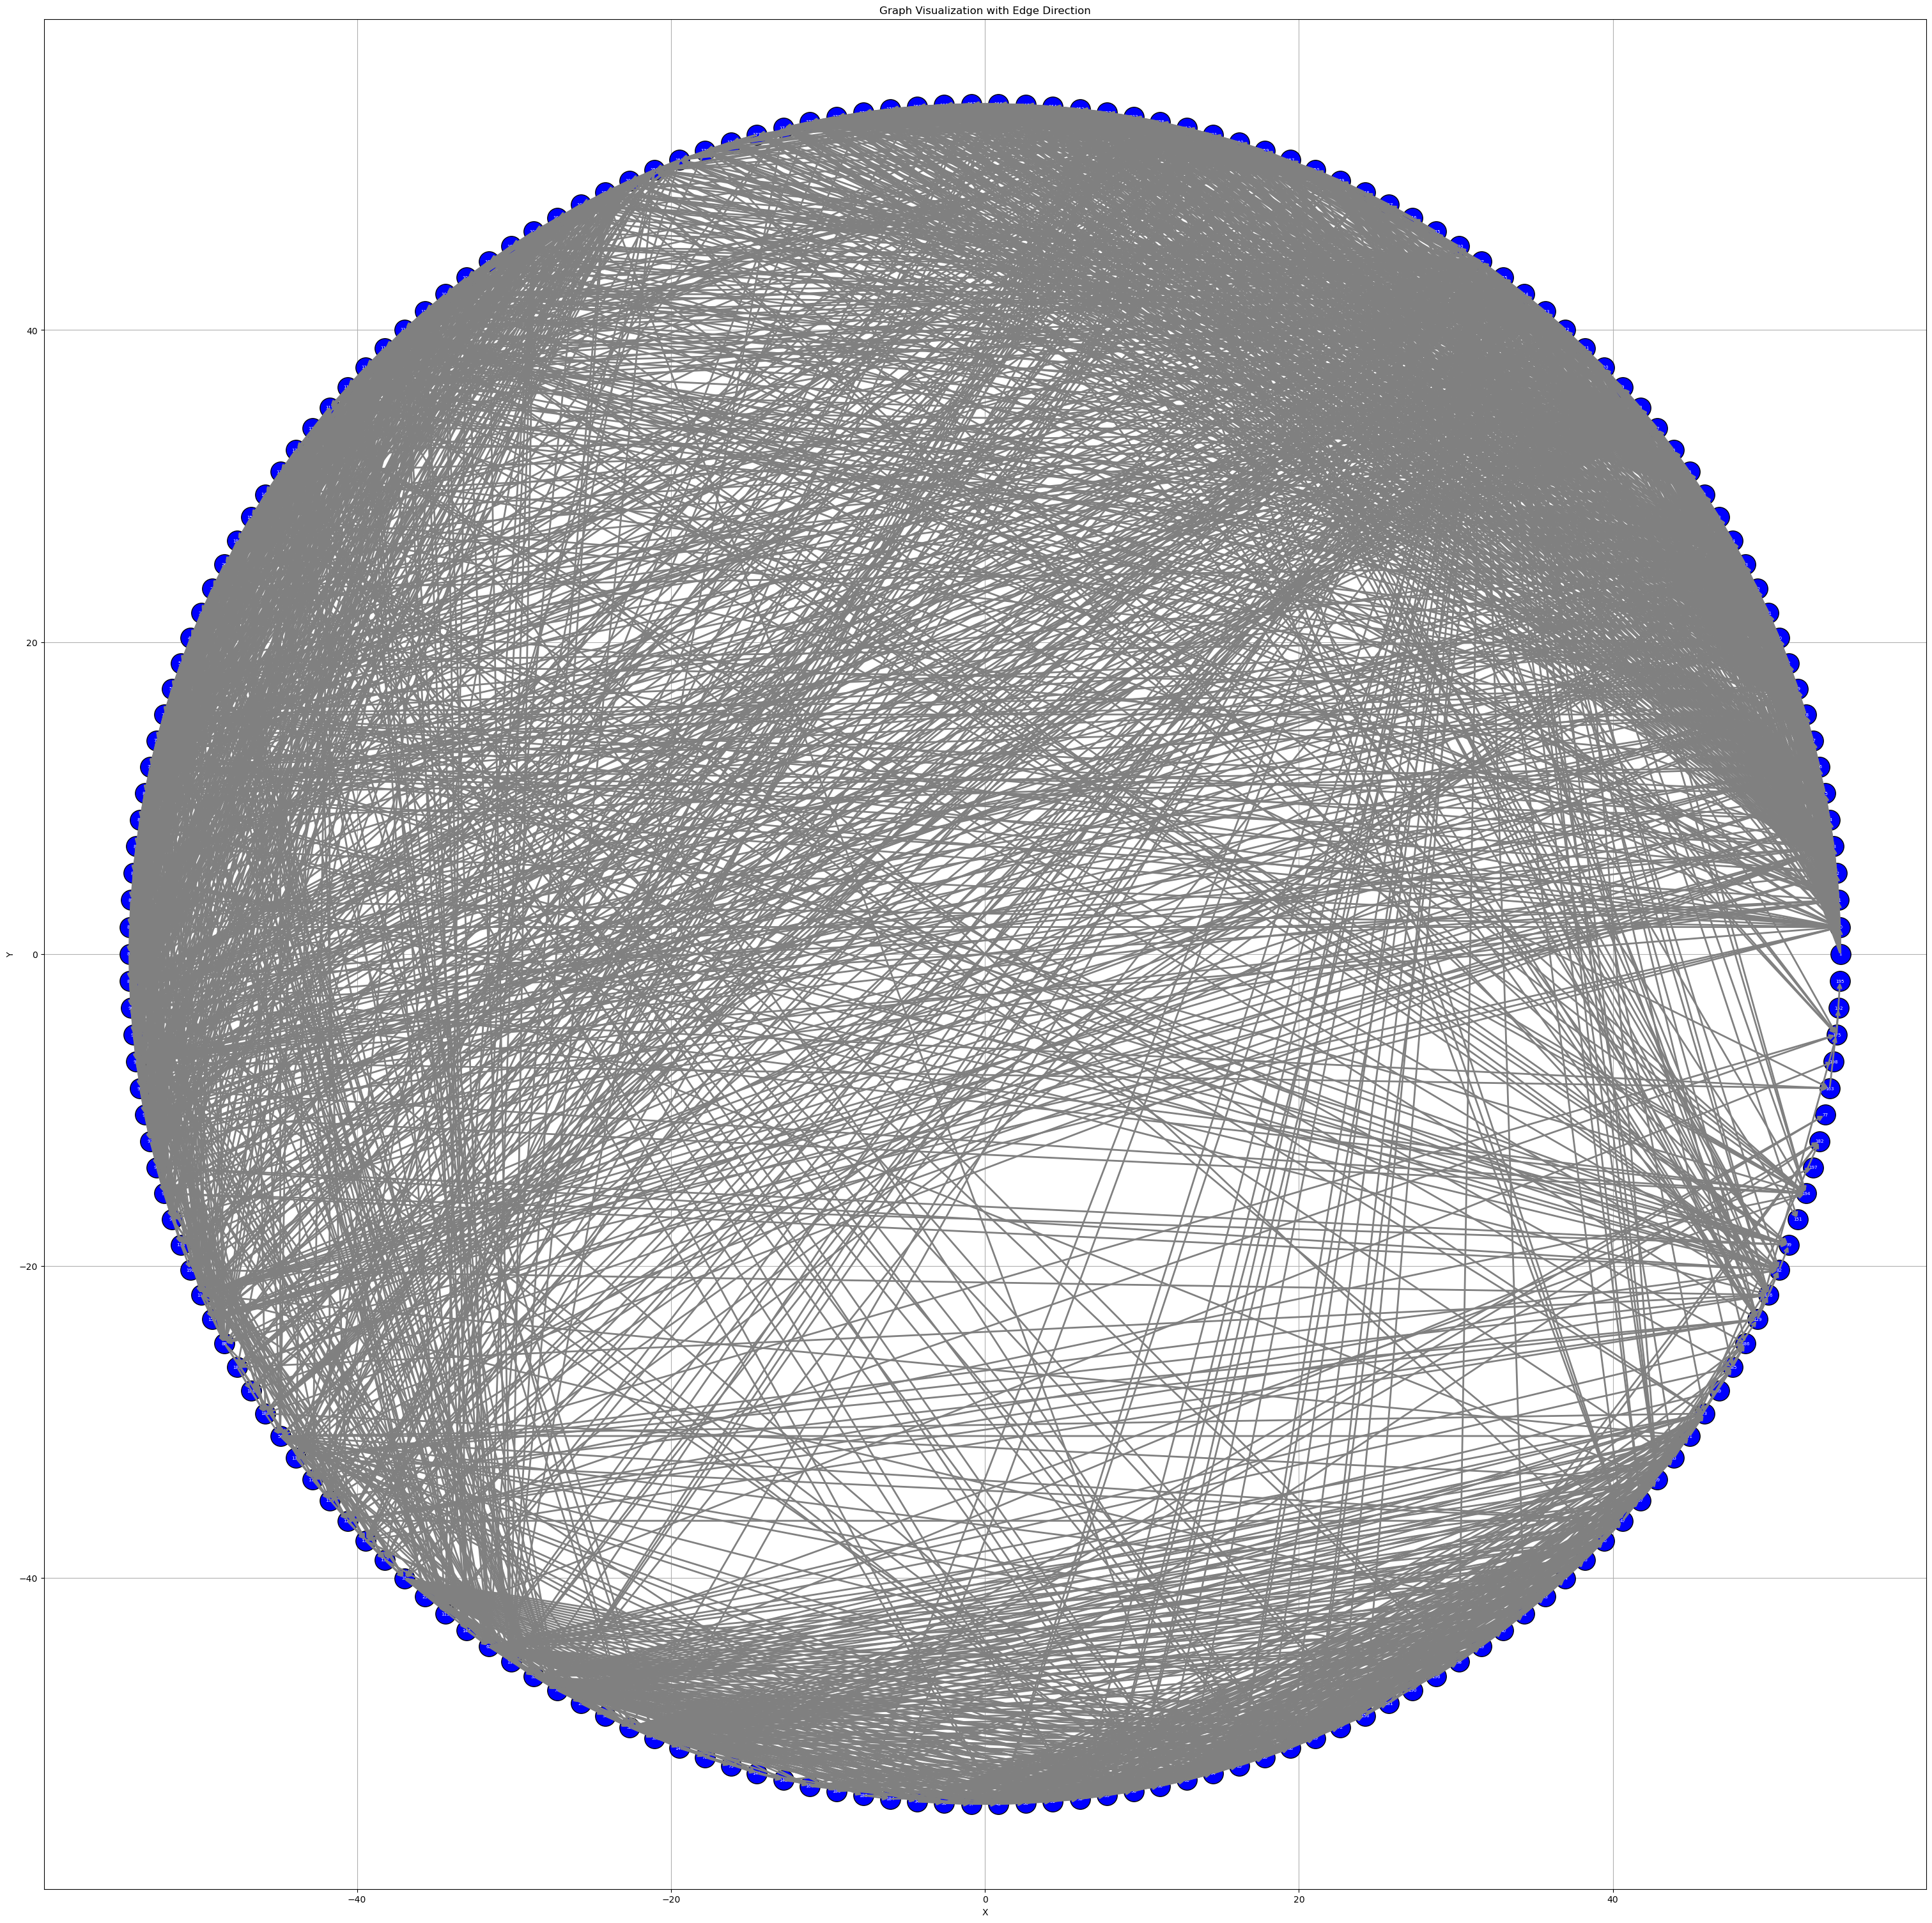

In [ ]:
# Parsing the data from the dot file:
G = pydot.graph_from_dot_file(url)[0]
#Convering the graph into our custom graph
graph = create_custom_graph(G) #O(V) + O(E) = O(V + E)
graph2 = create_custom_graph(G)
# Visualize the graph

fig_size=5+len(graph.vertices)/6 # new line
radius=5+len(graph.vertices)/4 # new line

graph.visualize_graph(fig_size,radius) #O(V + E)




In [ ]:
def floyd_warshall(G):

  D_array = np.full((len(G.vertices), len(G.vertices)), np.inf)

  for edge in G.edges:
      D_array[int(edge.start.id)-1][int(edge.end.id)-1] = int(edge.weight)
      D_array[int(edge.end.id)-1][int(edge.start.id)-1] = int(edge.weight)

  for v in G.vertices:
    D_array[int(v.id)-1][int(v.id)-1] = 0

  for k in G.vertices:
    for i in G.vertices:
      for j in G.vertices:
        k_idx = int(k.id) - 1
        i_idx = int(i.id) - 1
        j_idx = int(j.id) - 1

        if D_array[i_idx][j_idx] > D_array[i_idx][k_idx] + D_array[k_idx][j_idx]:
          D_array[i_idx][j_idx] = D_array[i_idx][k_idx] + D_array[k_idx][j_idx]

  return(D_array)

for v in graph.vertices:
  if v.id == '"\\n"':
      graph.vertices.remove(v)

D_array = floyd_warshall(graph)
D_array3 = floyd_warshall(graph)

print(D_array)


[[0. 1. 1. ... 4. 4. 4.]
 [1. 0. 2. ... 3. 3. 3.]
 [1. 2. 0. ... 3. 3. 3.]
 ...
 [4. 3. 3. ... 0. 3. 4.]
 [4. 3. 3. ... 3. 0. 4.]
 [4. 3. 3. ... 4. 4. 0.]]


In [ ]:
from sklearn.manifold import MDS

def projection_visualization(X_tranformed, vertices, edges):

    plt.figure(figsize=(8, 6))
    for i, vertex in enumerate(vertices):
        plt.scatter(X_transformed[i, 0], X_transformed[i, 1], color='blue')
        plt.text(X_transformed[i, 0], X_transformed[i, 1], f'{vertex.id}', fontsize=9)

    for edge in edges:
        plt.plot([edge.start.x, edge.end.x], [edge.start.y, edge.end.y], color='gray', alpha=0.5)


    plt.title('MDS Visualization using  Jazz network with eps = 0.0000001 ')
    #plt.xlabel('x')
    #plt.ylabel('y')
    #plt.legend()
    plt.grid(False)
    plt.axis('off')
    plt.show()

C:\Users\panos\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Convergences: 7956.939696849569
Best_iter: 461


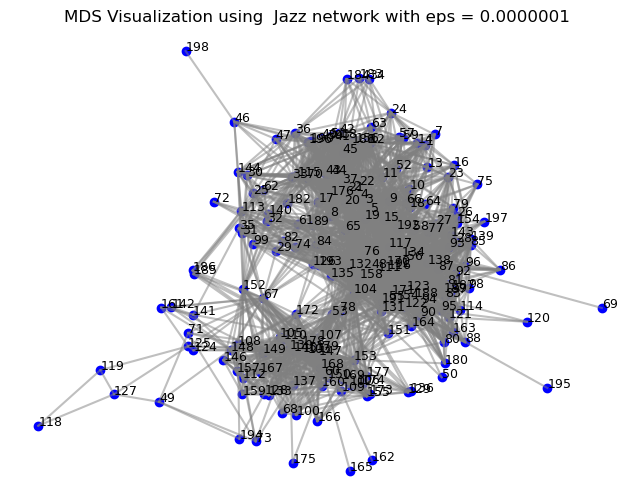

In [ ]:
#Apply MDS


mds = MDS(n_components=2, dissimilarity='precomputed', max_iter = 400, eps = 0.0001)
X_transformed = mds.fit_transform(D_array)

for i in range(len(X_transformed)):
  for v in graph.vertices:
    if v.id == str(i+1):
      v.x = X_transformed[i][0]
      v.y = X_transformed[i][1]

convergences = mds.stress_
print("Convergences:", convergences)
print("Best_iter:", mds.n_iter_)

projection_visualization(X_transformed, graph.vertices, graph.edges)


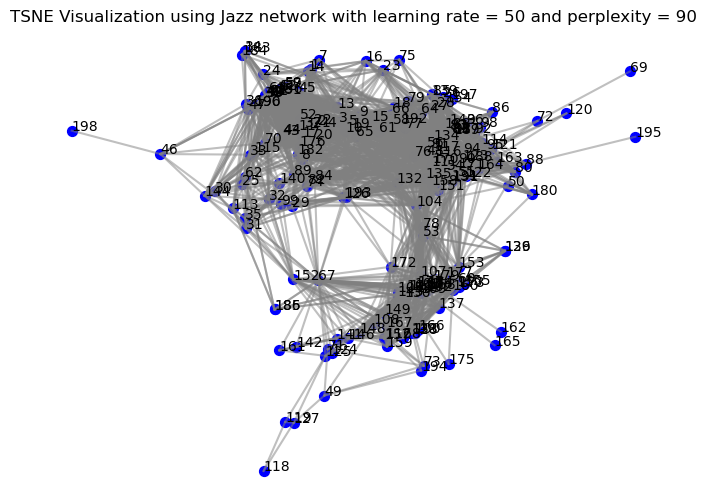

KL Divergence: 0.011955120600759983
Number of iterations: 699
learning rate 50


In [ ]:
#Apply t-SNE
import numpy as np
from sklearn.manifold import TSNE


# Visualize the embedded points
def visualize_TSNE(X_transformed, vertices, edges):

    plt.figure(figsize=(8, 6))
    plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c='b', s=50)
    for i, vertex in enumerate(vertices):
        plt.text(X_transformed[i, 0], X_transformed[i, 1], str(vertex.id))

    for edge in edges:
        plt.plot([edge.start.x, edge.end.x], [edge.start.y, edge.end.y], color='gray', alpha=0.5)
    #plt.xlabel('x')
    #plt.ylabel('y')
    plt.title('TSNE Visualization using Jazz network with learning rate = 50 and perplexity = 90' )
    plt.grid(False)
    plt.axis('off')
    plt.show()

tsne = TSNE(n_components=2,init="random",metric="precomputed", perplexity = 190, n_iter = 5000, learning_rate = 50  ,min_grad_norm = 0.0000000001)
X_transformed1 = tsne.fit_transform(D_array3)

for i in range(len(X_transformed)):
  for v in graph2.vertices:
    if v.id == str(i+1):
      v.x = X_transformed1[i][0]
      v.y = X_transformed1[i][1]

# Visualize the embedded points
visualize_TSNE(X_transformed1, graph2.vertices, graph2.edges )

print("KL Divergence:", tsne.kl_divergence_)
print("Number of iterations:", tsne.n_iter_)
print("learning rate", tsne.learning_rate_)